### Importing Libraries and Defining Path

In [1]:
import pandas as pd
from pathlib import Path as p
import warnings

warnings.filterwarnings("ignore")

face_data_root = "D:\\FACE-BMI\\face_dataset"
dataset = "D:\\FACE-BMI\\dataset\\bmi_data_new.csv"

### Utility Function - 1

In [2]:
def get_index_of_digit(string):
    import re
    match = re.search("\d", p(string).stem)
    return match.start(0)

def calculate_bmi(height, weight):
    return weight / (height ** 2)

### Prepare the Dataframe and Calculate BMI

In [3]:
from glob import glob
all_files = glob(face_data_root+"/*")
all_jpgs = sorted([img for img in all_files if ".jpg" in img or ".jpeg" in img or "JPG" in img])
print("Total {} photos ".format(len(all_jpgs)))

Total 254 photos 


In [4]:
id_path = [(p(images).stem[:(get_index_of_digit(p(images).stem))],images) for  images in all_jpgs ]
image_df = pd.DataFrame(id_path,columns=['UID','path'])
profile_df = pd.read_csv(dataset)
profile_df.head()

,id,UID,name,height,weight
0,1,akshay,akshay kumar,1.78,80
1,2,ja,john abraham,1.82,94
2,3,varun,varun dhawan,1.68,78
3,4,tiger,Tiger shroff,1.75,72
4,5,salman,Salman khan,1.74,75


In [5]:
profile_df['BMI'] = profile_df.apply(lambda row: calculate_bmi(row['height'],row['weight']),axis=1)
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      50 non-null     int64  
 1   UID     50 non-null     object 
 2   name    50 non-null     object 
 3   height  50 non-null     float64
 4   weight  50 non-null     int64  
 5   BMI     50 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 2.5+ KB


In [6]:
data_df = image_df.merge(profile_df)
data_df

,UID,path,id,name,height,weight,BMI
0,akshay,D:\FACE-BMI\face_dataset\akshay1.jpeg,1,akshay kumar,1.78,80,25.249337
1,akshay,D:\FACE-BMI\face_dataset\akshay10.jpg,1,akshay kumar,1.78,80,25.249337
2,akshay,D:\FACE-BMI\face_dataset\akshay11.jpg,1,akshay kumar,1.78,80,25.249337
3,akshay,D:\FACE-BMI\face_dataset\akshay12.jpg,1,akshay kumar,1.78,80,25.249337
4,akshay,D:\FACE-BMI\face_dataset\akshay13.jpg,1,akshay kumar,1.78,80,25.249337
...,...,...,...,...,...,...,...
249,vimal,D:\FACE-BMI\face_dataset\vimal1.jpg,45,vimal,1.75,69,22.530612
250,vishal,D:\FACE-BMI\face_dataset\vishal1.jpg,35,vishal,1.80,73,22.530864
251,vishnuvishal,D:\FACE-BMI\face_dataset\vishnuvishal1.jpg,46,vishnuvishal,1.77,73,23.301095
252,vjantony,D:\FACE-BMI\face_dataset\vjantony1.jpg,49,vjantony,1.75,67,21.877551


### Extract Face Embedding using Facenet Pretrained Architecture

In [7]:
import face_recognition
import numpy as np

### Utility Function - 2

In [15]:
face_count = 0

def get_face_encoding(image_path):
    global face_count
    face_count = face_count + 1
    picture_of_me = face_recognition.load_image_file(image_path)
    my_face_encoding = face_recognition.face_encodings(picture_of_me)
    if not my_face_encoding:
        print("no face found !!!")
        return np.zeros(128).tolist()
    return my_face_encoding[0].tolist()

In [16]:
all_faces = []

for images in data_df.path:
    face_enc = get_face_encoding(images)
    all_faces.append(face_enc)

print(f"Found {face_count} of {len(all_jpgs)} Faces")

no face found !!!
no face found !!!
no face found !!!
Found 254 of 254 Faces


### Extracting Data and Creating Splits

In [17]:
X=np.array(all_faces)
y=np.array(all_faces)

In [18]:
y_height = data_df.height.values
y_weight = data_df.weight.values
y_BMI = data_df.BMI.values

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_height_train, y_height_test, y_weight_train, y_weight_test ,y_BMI_train, y_BMI_test = train_test_split(X, y_height,y_weight,y_BMI, random_state=1)

### Utility Function - 3

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

def report_goodness(model,X_test,y_test,predictor_log=True):
    y_pred = model.predict(X_test)
    y_true = y_test
    if predictor_log:
        y_true = np.log(y_test)
    print(f"Mean squared error: {mean_squared_error(y_true, y_pred)}")
    print(f"Variance score:{r2_score(y_true, y_pred)}")
    
    errors = abs(y_pred - y_true)
    mape = 100 * np.mean(errors / y_true)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

## Model selection 

In [21]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

### Simple Linear Regression

In [22]:
print("Defining Height Model")
lr_model_height = LinearRegression()
lr_model_height = lr_model_height.fit(X_train,np.log(y_height_train))
lr_height_accuracy = report_goodness(lr_model_height,X_test,y_height_test)

print("\nDefining Weigth Model")
lr_model_weight = LinearRegression()
lr_model_weight = lr_model_weight.fit(X_train,np.log(y_weight_train))
lr_weight_accuracy = report_goodness(lr_model_weight,X_test,y_weight_test)

print("\nDefining BMI Model")
lr_model_BMI = LinearRegression()
lr_model_BMI = lr_model_BMI.fit(X_train,np.log(y_BMI_train))
lr_bmi_accuracy = report_goodness(lr_model_BMI,X_test,y_BMI_test)

Defining Height Model
Mean squared error: 0.001053435591645059
Variance score:0.07940225751201224
Model Performance
Average Error: 0.0258 degrees.
Accuracy = 95.25%.

Defining Weigth Model
Mean squared error: 0.008318816086134304
Variance score:0.43335817648645114
Model Performance
Average Error: 0.0765 degrees.
Accuracy = 98.22%.

Defining BMI Model
Mean squared error: 0.006065600894089857
Variance score:0.373871629629013
Model Performance
Average Error: 0.0614 degrees.
Accuracy = 98.05%.


### Ridge Linear Regression

In [23]:
print("Defining Height Model")
ridge_model_height = Ridge(fit_intercept=True, alpha=0.0015, random_state=4)
ridge_model_height = ridge_model_height.fit(X_train,np.log(y_height_train))
ridge_model_height_accuracy = report_goodness(ridge_model_height,X_test,y_height_test)

print("\nDefining Weight Model")
ridge_model_weight = Ridge(fit_intercept=True, alpha=0.0015, random_state=4)
ridge_model_weight = ridge_model_weight.fit(X_train,np.log(y_weight_train))
ridge_model_weight_accuracy = report_goodness(ridge_model_weight,X_test,y_weight_test)

print("\nDefining BMI Model")
ridge_model_BMI = Ridge(fit_intercept=True, alpha=0.0015, random_state=4)
ridge_model_BMI = ridge_model_BMI.fit(X_train,np.log(y_BMI_train))
ridge_model_bmi_accuracy = report_goodness(ridge_model_BMI,X_test,y_BMI_test)

Defining Height Model
Mean squared error: 0.0006829212426303398
Variance score:0.4031948804000418
Model Performance
Average Error: 0.0217 degrees.
Accuracy = 96.02%.

Defining Weight Model
Mean squared error: 0.0075653229198650125
Variance score:0.484682876698478
Model Performance
Average Error: 0.0693 degrees.
Accuracy = 98.38%.

Defining BMI Model
Mean squared error: 0.0050573285785836435
Variance score:0.4779516561294731
Model Performance
Average Error: 0.0507 degrees.
Accuracy = 98.40%.


### Random Forest Regressor

In [24]:
print("\nDefining Height Model")
rf_model_height = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
rf_model_height = rf_model_height.fit(X_train,np.log(y_height_train))
rf_height_accuracy = report_goodness(rf_model_height,X_test,y_height_test)

print("\nDefining Weigth Model")
rf_model_weight = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
rf_model_weight = rf_model_weight.fit(X_train,np.log(y_weight_train))
rf_weight_accuracy = report_goodness(rf_model_weight,X_test,y_weight_test)

print("\nDefining BMI Model")
rf_model_BMI = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
rf_model_BMI = rf_model_BMI.fit(X_train,np.log(y_BMI_train))
rf_bmi_accuracy = report_goodness(rf_model_BMI,X_test,y_BMI_test)


Defining Height Model
Mean squared error: 0.0006826519082135541
Variance score:0.4034302518437578
Model Performance
Average Error: 0.0208 degrees.
Accuracy = 96.19%.

Defining Weigth Model
Mean squared error: 0.005273172910184851
Variance score:0.6408142357528794
Model Performance
Average Error: 0.0587 degrees.
Accuracy = 98.62%.

Defining BMI Model
Mean squared error: 0.004702419280313645
Variance score:0.5145875615303426
Model Performance
Average Error: 0.0469 degrees.
Accuracy = 98.51%.


### Random Forest Regressor Using Hyperparameter Tuning

In [25]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [26]:
rf = RandomForestRegressor()

print("\nDefining Height Model")
rf_new_height_model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_new_height_model.fit(X_train,np.log(y_height_train))
rf_new_height_accuracy = report_goodness(rf_new_height_model,X_test,y_height_test)

print("\nDefining Weigth Model")
rf_new_weight_model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_new_weight_model.fit(X_train,np.log(y_weight_train))
rf_new_weight_accuracy = report_goodness(rf_new_weight_model,X_test,y_weight_test)

print("\nDefining BMI Model")
rf_new_BMI_model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_new_BMI_model.fit(X_train,np.log(y_BMI_train))
rf_new_bmi_accuracy = report_goodness(rf_new_BMI_model,X_test,y_BMI_test)



Defining Height Model
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mean squared error: 0.0003589646115940827
Variance score:0.6863006967986187
Model Performance
Average Error: 0.0139 degrees.
Accuracy = 97.45%.

Defining Weigth Model
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mean squared error: 0.003788603507130895
Variance score:0.7419366917572918
Model Performance
Average Error: 0.0457 degrees.
Accuracy = 98.93%.

Defining BMI Model
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mean squared error: 0.0030040952034336363
Variance score:0.6898989453793534
Model Performance
Average Error: 0.0340 degrees.
Accuracy = 98.91%.


### Kernel Ridge

In [27]:
print("\nDefining Height Model")
kernel_ridge_model_height = KernelRidge(kernel='rbf', gamma=0.21,alpha=0.0017)
kernel_ridge_model_height = kernel_ridge_model_height.fit(X_train,np.log(y_height_train))
kernel_ridge_height_accuracy = report_goodness(kernel_ridge_model_height,X_test,y_height_test)

print("\nDefining Weigth Model")
kernel_ridge_model_weight = KernelRidge(kernel='rbf', gamma=0.21,alpha=0.0017)
kernel_ridge_model_weight = kernel_ridge_model_weight.fit(X_train,np.log(y_weight_train))
kernel_ridge_weight_accuracy = report_goodness(kernel_ridge_model_weight,X_test,y_weight_test)

print("\nDefining BMI Model")
kernel_ridge_model_BMI = KernelRidge(kernel='rbf', gamma=0.21,alpha=0.0017)
model_BMI = kernel_ridge_model_BMI.fit(X_train,np.log(y_BMI_train))
kernel_ridge_bmi_accuracy = report_goodness(model_BMI,X_test,y_BMI_test)


Defining Height Model
Mean squared error: 0.00033572444853156494
Variance score:0.7066102836590703
Model Performance
Average Error: 0.0145 degrees.
Accuracy = 97.32%.

Defining Weigth Model
Mean squared error: 0.004354298677907784
Variance score:0.7034039799143039
Model Performance
Average Error: 0.0485 degrees.
Accuracy = 98.86%.

Defining BMI Model
Mean squared error: 0.003385572688554717
Variance score:0.6505205094646501
Model Performance
Average Error: 0.0401 degrees.
Accuracy = 98.73%.


### Model Selection Report

In [28]:
report = {
    'models':["Linear Regression","Ridge Linear Regression","Random Forest Regressor","Random Forest Regressor(HT)","Kernel ridge"],
    'weight':[lr_weight_accuracy,ridge_model_weight_accuracy,rf_weight_accuracy,rf_new_weight_accuracy,kernel_ridge_weight_accuracy],
    'height':[lr_height_accuracy,ridge_model_height_accuracy,rf_height_accuracy,rf_new_height_accuracy,kernel_ridge_height_accuracy],
    'bmi':[lr_bmi_accuracy,ridge_model_bmi_accuracy,rf_bmi_accuracy,rf_new_bmi_accuracy,kernel_ridge_bmi_accuracy]
}

report_df = pd.DataFrame(report)
report_df

,models,weight,height,bmi
0,Linear Regression,98.219965,95.250986,98.050062
1,Ridge Linear Regression,98.379823,96.017262,98.402055
2,Random Forest Regressor,98.624357,96.190849,98.513821
3,Random Forest Regressor(HT),98.925937,97.454386,98.914373
4,Kernel ridge,98.861501,97.322592,98.727816


#### From the above report we can to conclude that `Random Forest Regressor with RandomizedSearch CV` is giving better accuracy for all the models, we are proceding with that model further.

### Save the Model

In [29]:
import joblib
model_path = "D:\\FACE-BMI\\models"

In [30]:
joblib.dump(rf_new_height_model, f'{model_path}\\height_model')
joblib.dump(rf_new_weight_model, f'{model_path}\\weight_model')
joblib.dump(rf_new_BMI_model, f'{model_path}\\bmi_model')

print("Models Saved Successfully")

Models Saved Successfully


### Load the Model from Disk

In [31]:
height_model = joblib.load(f'{model_path}\\height_model')
weight_model = joblib.load(f'{model_path}\\weight_model')
bmi_model = joblib.load(f'{model_path}\\bmi_model')

### Testing the Model Builded 

### Utility Function - 4

In [32]:
import numpy

def patch_asscalar(a):
    return a.item()

setattr(numpy, "asscalar", patch_asscalar)

def predict_height_width_BMI(test_image,height_model,weight_model,bmi_model):
    test_array = np.expand_dims(np.array(get_face_encoding(test_image)),axis=0)
    height = np.asscalar(np.exp(height_model.predict(test_array)))
    weight = np.asscalar(np.exp(weight_model.predict(test_array)))
    bmi = np.asscalar(np.exp(bmi_model.predict(test_array)))
    return {'height':height,'weight':weight,'bmi':bmi}

### Prediction

In [33]:
from IPython.display import Image

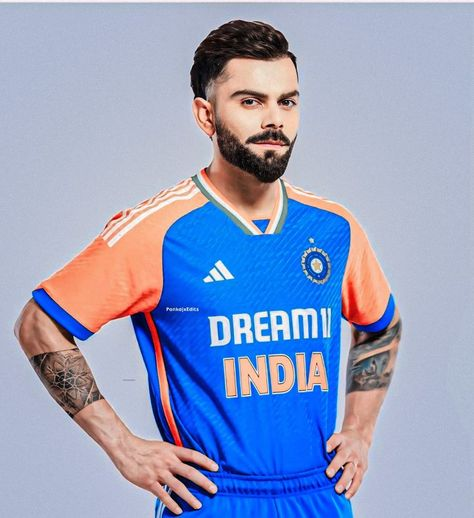

In [34]:
test_image = "D:\\FACE-BMI\\dataset\\test\\virat.jpeg"
Image(test_image)

In [35]:
predict_height_width_BMI(test_image,height_model,weight_model,bmi_model)

{'height': 1.715572539412927,
 'weight': 77.12419010166147,
 'bmi': 26.085243020708756}

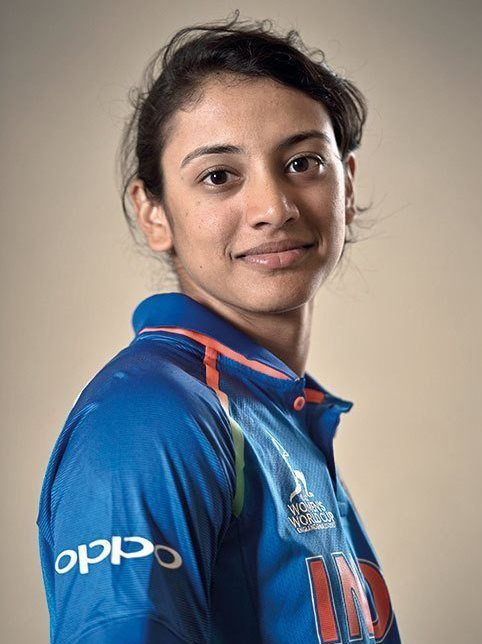

In [36]:
test_image = "D:\\FACE-BMI\\dataset\\test\\smirti.jpeg"
Image(test_image)

In [37]:
predict_height_width_BMI(test_image,height_model,weight_model,bmi_model)

{'height': 1.6690252444799227,
 'weight': 61.57928891755291,
 'bmi': 22.703185292858254}